<a href="https://colab.research.google.com/github/anelglvz/Deep_Learning/blob/main/Temporal_Fusion_Transformer_for_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch pytorch-lightning pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import  QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


### Data
More details about data in: https://challengedata.ens.fr/challenges/89

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Contextual variables
* date d: YYYYMMDD is the date of the train id run
* train k: 1, 2, …, 55 train id (unique by day d)
* station s: AA, AB, AC,… is the station id
* hour: HH:00:00 is the time slot
* way: 0, 1 is the train way with 0 (toward Paris) or 1 (toward suburb)
* composition: 1, 2 is the number of train units (one or two)

Lags variables
* p1q0 ∈ [0,1] is the occupancy rate of the previous train k-1 at the same station s
* p2q0 ∈ [0,1] is the occupancy rate of the second previous train k-2 at the same station s
* p3q0 ∈ [0,1] is the occupancy rate of the third previous train k-3 at the same station s
* p0q1 ∈ [0,1] is the occupancy rate of the same train k at the previous station s-1
* p0q2 ∈ [0,1] is the occupancy rate of the same train k at the second previous station s-2
* p0q3 ∈ [0,1] is the occupancy rate of the same train k at the third previous station s-3

The actual occupancy rate is: p0q0 ∈ [0,1] which is crowding factor/occupancy rate, for a stop which is a train k at a station s for a day d.

In [ ]:
path = '/content/drive/MyDrive/Curso-Deep-Learning/Transformers_for_Time_Series/'
Xtrain = pd.read_csv(path+'Xtrain.csv')
index = Xtrain.index
print(Xtrain.shape)
Xtrain

(31119, 12)


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN
31115,2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN
31116,2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN
31117,2019-03-21,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN


In [ ]:
Xtrain.info()

In [ ]:
Xtrain['date'] = pd.to_datetime(Xtrain['date'])
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         31119 non-null  datetime64[ns]
 1   train        31119 non-null  int64         
 2   way          31119 non-null  int64         
 3   station      31119 non-null  object        
 4   hour         27915 non-null  object        
 5   composition  31119 non-null  int64         
 6   p1q0         29067 non-null  float64       
 7   p2q0         26974 non-null  float64       
 8   p3q0         24935 non-null  float64       
 9   p0q1         27917 non-null  float64       
 10  p0q2         24720 non-null  float64       
 11  p0q3         21527 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 2.8+ MB


In [ ]:
datatrain = Xtrain.copy()
datatrain.set_index('date', inplace=True)
datatrain

,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
date,,,,,,,,,,,
2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091
2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106
2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111
2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108
2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN
2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN
2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN


In [ ]:
ytrain = pd.read_csv(path+'Ytrain.csv')
print(ytrain.shape)
ytrain

(31119, 2)


,Unnamed: 0,p0q0
0,1,0.216
1,2,0.216
2,3,0.227
3,4,0.229
4,5,0.225
...,...,...
31114,31115,0.111
31115,31116,0.143
31116,31117,0.139
31117,31118,0.117


In [ ]:
df = ytrain[['p0q0']]
df = df.set_index(datatrain.index, drop=True)
df

,p0q0
date,
2019-01-07,0.216
2019-01-08,0.216
2019-01-10,0.227
2019-01-11,0.229
2019-01-14,0.225
...,...
2019-05-13,0.111
2019-05-14,0.143
2019-05-15,0.139


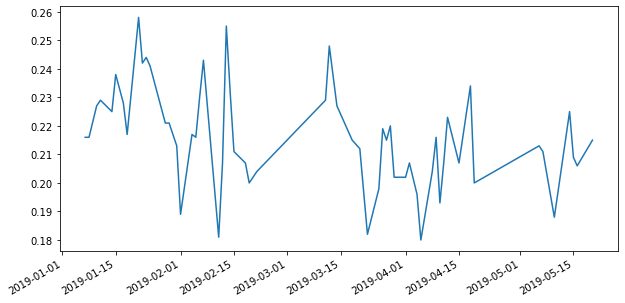

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:58])
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
datos = pd.concat([ytrain,Xtrain], axis=1)
datos = datos[['p0q0', 'date', 'p0q1',	'p0q2',	'p0q3','train', 'way', 'station', 'hour']]
datos = datos.dropna()
datos

,p0q0,date,p0q1,p0q2,p0q3,train,way,station,hour
0,0.216,2019-01-07,0.201,0.138,0.091,1,0,AD,06:00:00
1,0.216,2019-01-08,0.204,0.152,0.106,1,0,AD,06:00:00
2,0.227,2019-01-10,0.213,0.153,0.111,1,0,AD,06:00:00
3,0.229,2019-01-11,0.213,0.152,0.108,1,0,AD,06:00:00
4,0.225,2019-01-14,0.210,0.147,0.096,1,0,AD,06:00:00
...,...,...,...,...,...,...,...,...,...
30997,0.408,2019-05-13,0.451,0.450,0.374,9,0,BB,08:00:00
30998,0.487,2019-05-14,0.524,0.529,0.455,9,0,BB,08:00:00
30999,0.408,2019-05-15,0.453,0.469,0.379,9,0,BB,08:00:00
31000,0.412,2019-03-21,0.440,0.441,0.387,9,0,BB,08:00:00


In [ ]:
datos['hour'] = datos['hour'].apply(lambda x: int(x[1]))
datos

,p0q0,date,p0q1,p0q2,p0q3,train,way,station,hour
0,0.216,2019-01-07,0.201,0.138,0.091,1,0,AD,6
1,0.216,2019-01-08,0.204,0.152,0.106,1,0,AD,6
2,0.227,2019-01-10,0.213,0.153,0.111,1,0,AD,6
3,0.229,2019-01-11,0.213,0.152,0.108,1,0,AD,6
4,0.225,2019-01-14,0.210,0.147,0.096,1,0,AD,6
...,...,...,...,...,...,...,...,...,...
30997,0.408,2019-05-13,0.451,0.450,0.374,9,0,BB,8
30998,0.487,2019-05-14,0.524,0.529,0.455,9,0,BB,8
30999,0.408,2019-05-15,0.453,0.469,0.379,9,0,BB,8
31000,0.412,2019-03-21,0.440,0.441,0.387,9,0,BB,8


In [ ]:
datos.sort_values(by='date', inplace = True) 
datos = datos.reset_index(drop=True)
datos

,p0q0,date,p0q1,p0q2,p0q3,train,way,station,hour
0,0.216,2019-01-07,0.201,0.138,0.091,1,0,AD,6
1,0.074,2019-01-07,0.058,0.041,0.018,28,0,AL,7
2,0.201,2019-01-07,0.138,0.091,0.084,1,0,AM,6
3,0.408,2019-01-07,0.270,0.204,0.127,18,0,AI,8
4,0.210,2019-01-07,0.152,0.115,0.098,26,0,BF,8
...,...,...,...,...,...,...,...,...,...
21237,0.162,2019-05-20,0.140,0.111,0.126,11,0,AT,9
21238,0.233,2019-05-20,0.217,0.162,0.140,11,0,AD,9
21239,0.399,2019-05-20,0.360,0.295,0.249,26,0,AL,8
21240,0.282,2019-05-20,0.173,0.135,0.249,25,0,BH,7


In [ ]:
lista = datos['date'].unique()
len(lista)

74

In [ ]:
datos['time_idx'] = [np.where(lista == datos.loc[i,'date'])[0][0] for i in range(datos.shape[0])]
datos

,p0q0,date,p0q1,p0q2,p0q3,train,way,station,hour,time_idx
0,0.216,2019-01-07,0.201,0.138,0.091,1,0,AD,6,0
1,0.074,2019-01-07,0.058,0.041,0.018,28,0,AL,7,0
2,0.201,2019-01-07,0.138,0.091,0.084,1,0,AM,6,0
3,0.408,2019-01-07,0.270,0.204,0.127,18,0,AI,8,0
4,0.210,2019-01-07,0.152,0.115,0.098,26,0,BF,8,0
...,...,...,...,...,...,...,...,...,...,...
21237,0.162,2019-05-20,0.140,0.111,0.126,11,0,AT,9,73
21238,0.233,2019-05-20,0.217,0.162,0.140,11,0,AD,9,73
21239,0.399,2019-05-20,0.360,0.295,0.249,26,0,AL,8,73
21240,0.282,2019-05-20,0.173,0.135,0.249,25,0,BH,7,73


In [ ]:
max_prediction_length = 10
max_encoder_length = 44
training_cutoff = datos["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    datos[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target='p0q0',
    group_ids=["train", "station"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=[],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
    ],
    target_normalizer=GroupNormalizer(
        groups=[], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, datos, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

### Model

In [ ]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [ ]:
data[data['agency'] == 'Agency_25'][data[data['agency'] == 'Agency_25']['sku'] == 'SKU_04']['avg_yearly_household_income_2017']

279      95032
7230     95032
9081     95032
10804    95032
12373    95032
14111    95032
15887    95032
17786    95032
19476    95032
1857     95032
3665     95032
5467     95032
388      95032
7547     95032
9300     95032
11075    95032
12842    95032
14499    95032
16422    95032
18073    95032
19716    95032
2205     95032
3906     95032
5724     95032
820      95032
7737     95032
9474     95032
11216    95032
12959    95032
14718    95032
16579    95032
18479    95032
20215    95032
2624     95032
4277     95032
6065     95032
1237     95032
8109     95032
9809     95032
11570    95032
13306    95032
15064    95032
16804    95032
18553    95032
20302    95032
2899     95032
4555     95032
6362     95032
1575     95032
8415     95032
10246    95032
12029    95032
13725    95032
15479    95032
17238    95032
18935    95032
20723    95032
3281     95032
4918     95032
6862     95032
Name: avg_yearly_household_income_2017, dtype: int64

In [ ]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

Baseline

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


293.0088195800781

The best Learning Rate

In [ ]:
# configure network and trainer
trainer = pl.Trainer(
    max_epochs = 10,
    #accelerator='gpu', 
    #devices=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    optimizer='adam'
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.9/dist-packages/lightning_fabric/accelerators/cuda.py:236: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarn

Number of parameters in network: 17.0k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_df994608-98f9-4fa5-8bd8-db330c8c3065.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_df994608-98f9-4fa5-8bd8-db330c8c3065.ckpt


suggested learning rate: 4.073802778041128e-05


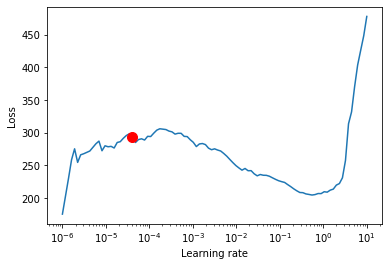

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

Modelo y Entrenamiento!!!

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    #accelerator='gpu',   #Descomentar si hay GPU disponible
    #devices=1,           #Descomentar si hay GPU disponible
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.008,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 17.0k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Optimize hyperparameters

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=2,
    max_epochs=5,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

Guardar y cargar el modelo entrenado!

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.1182)

Predicciones

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

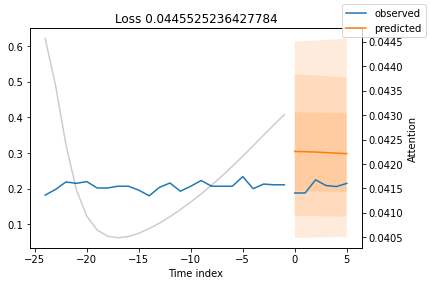

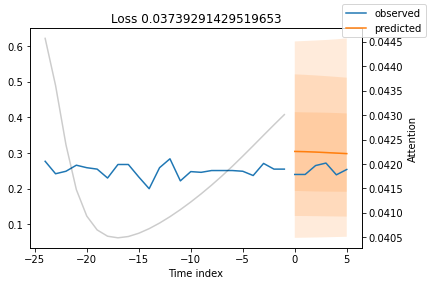

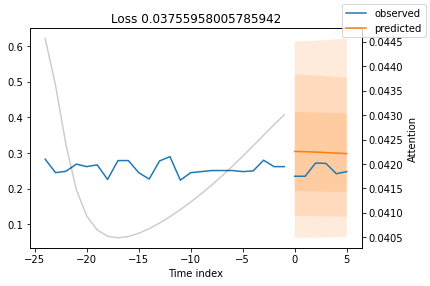

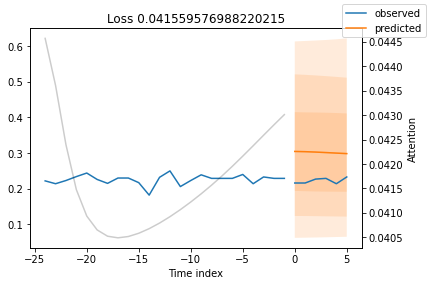

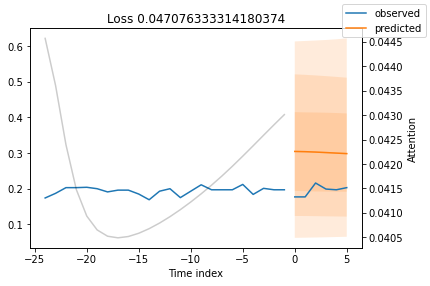

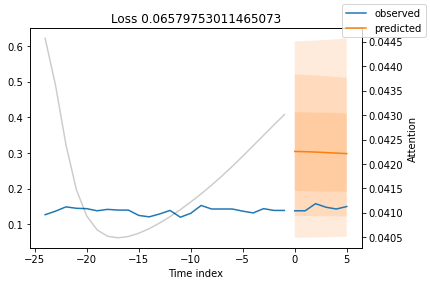

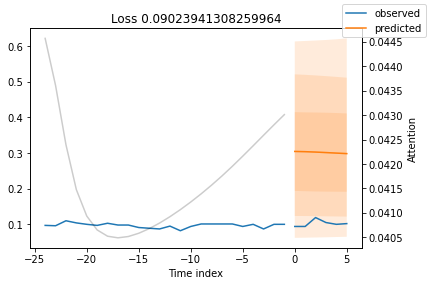

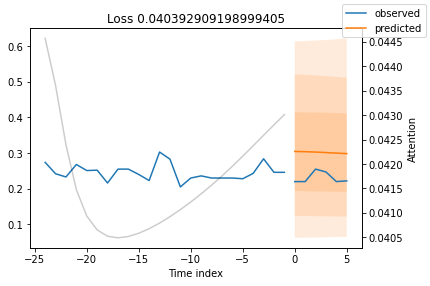

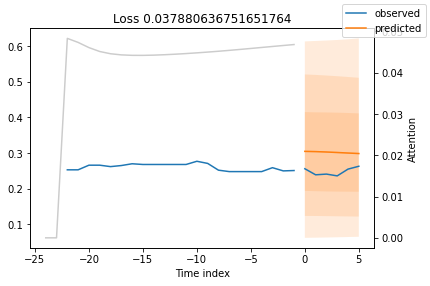

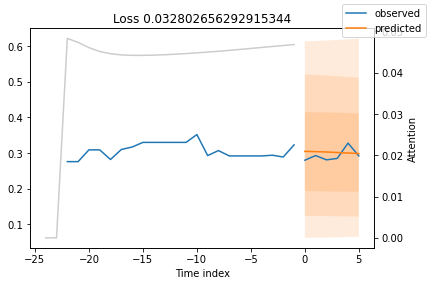

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6


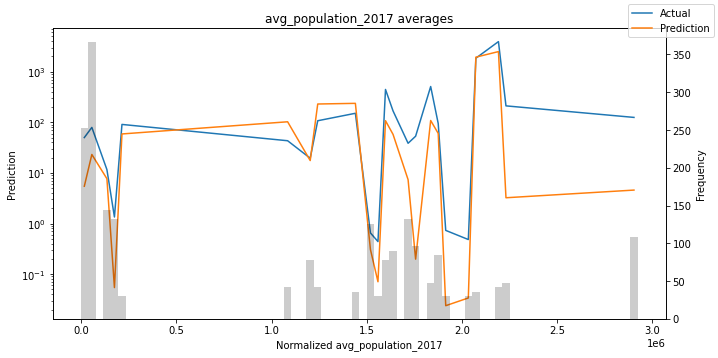

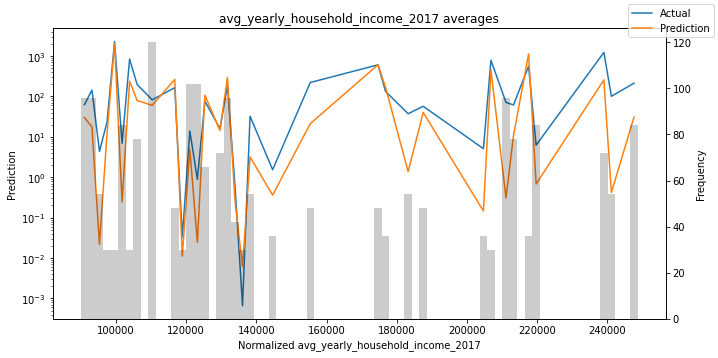

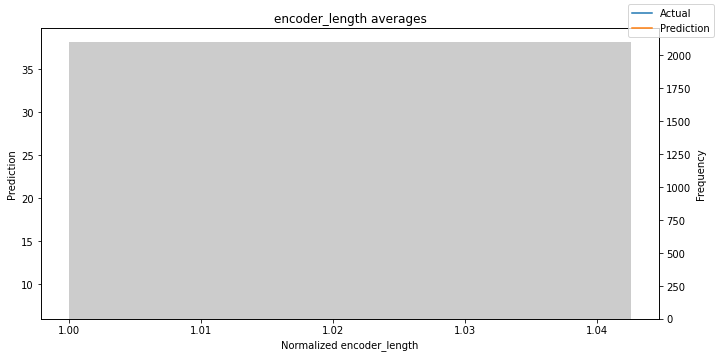

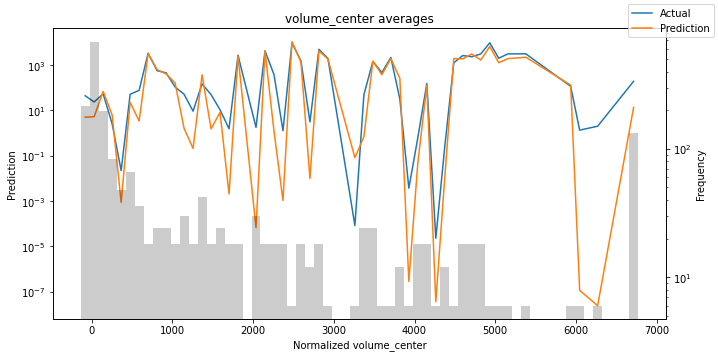

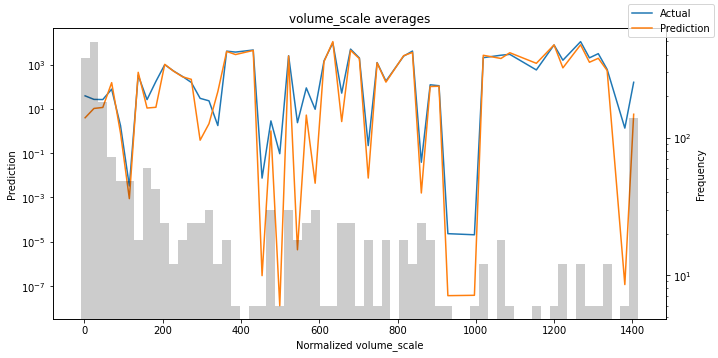

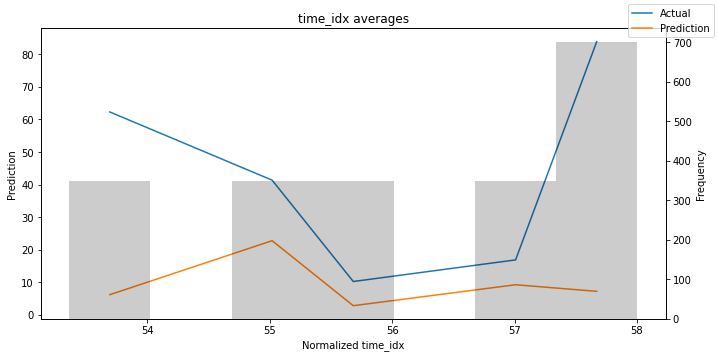

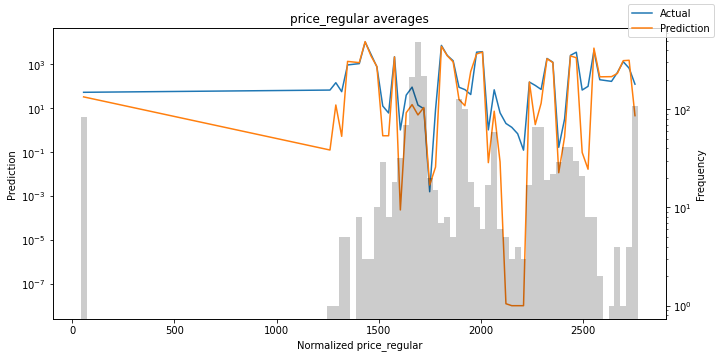

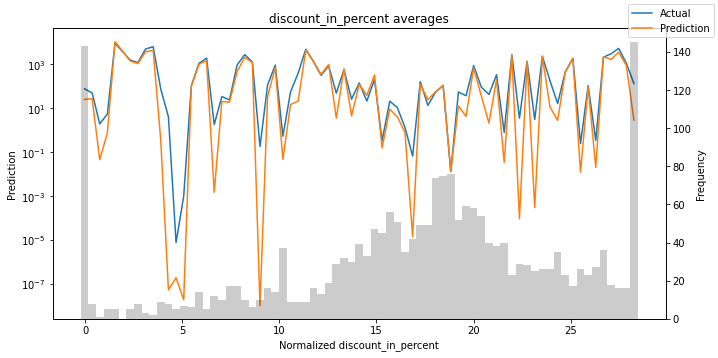

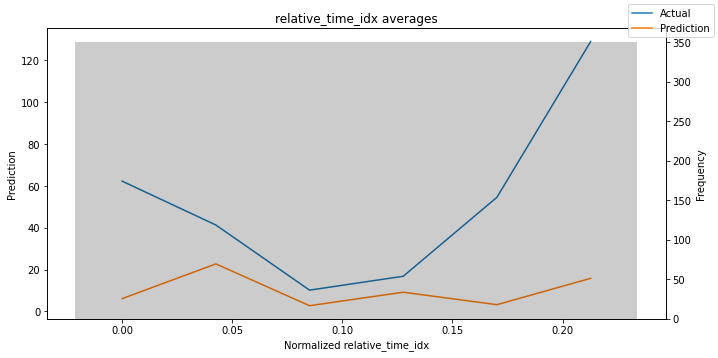

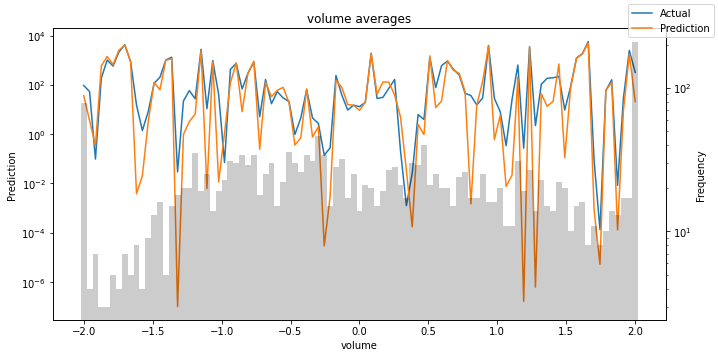

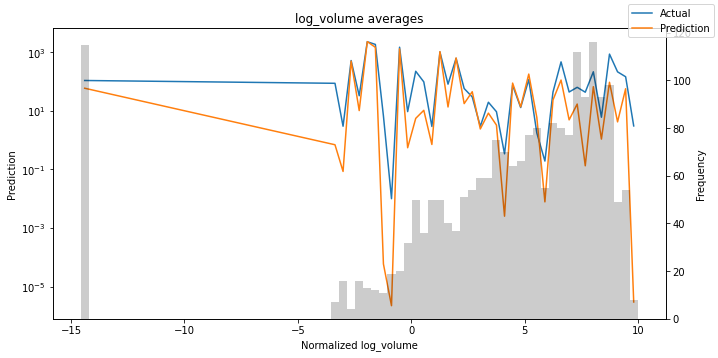

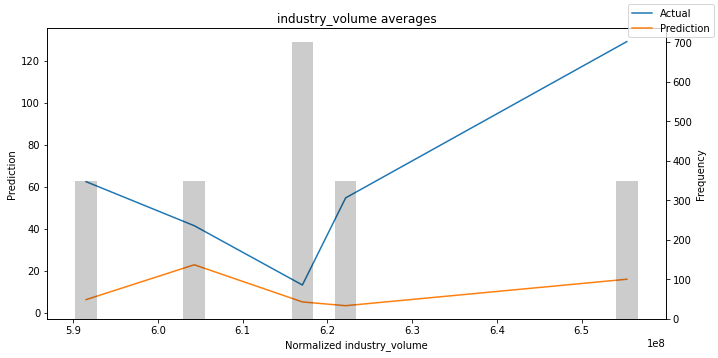

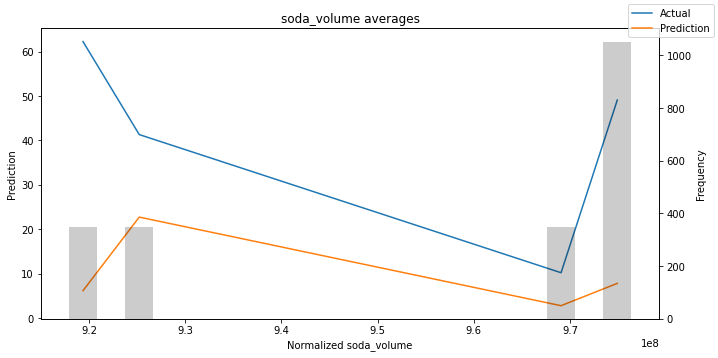

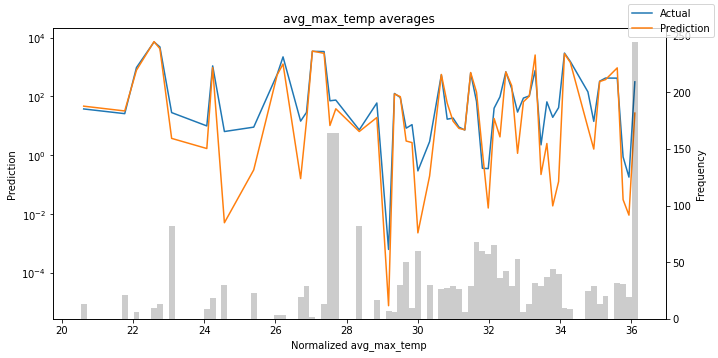

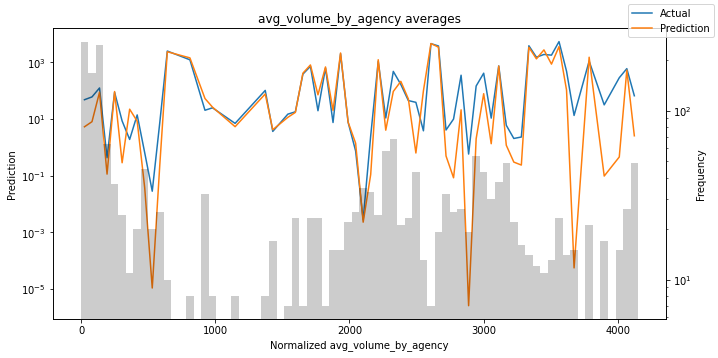

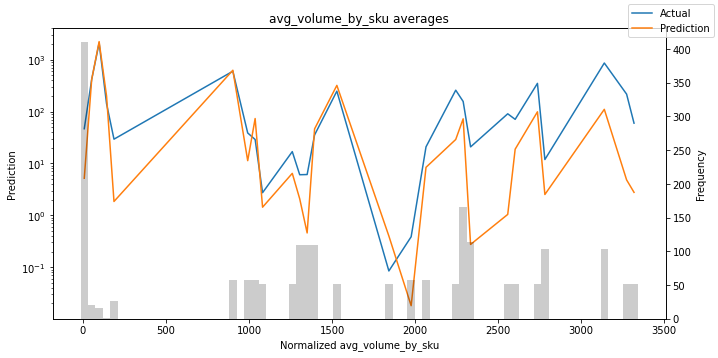

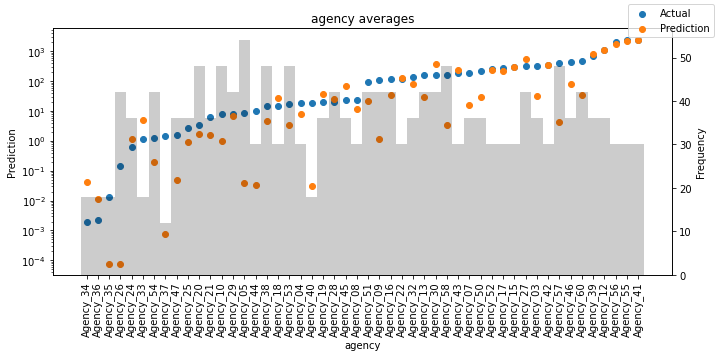

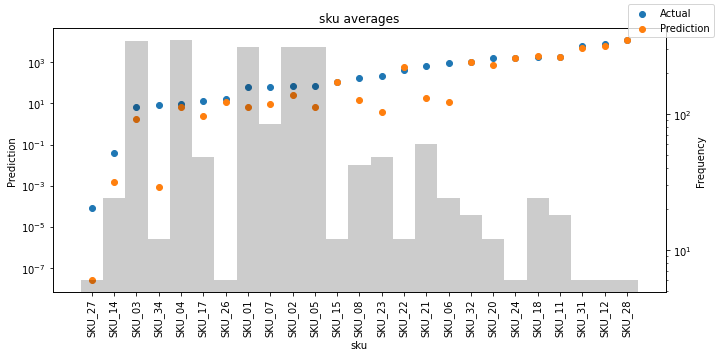

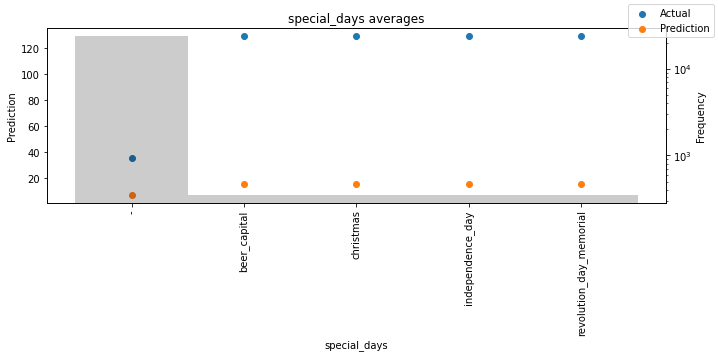

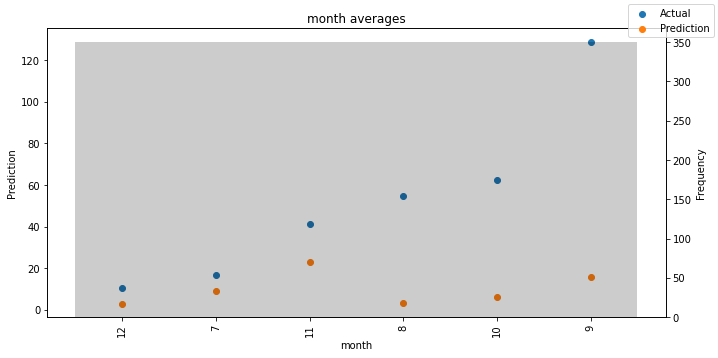

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

Referencia:
https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html